In [7]:
import os
import sys
import json
import datetime
import numpy as np
import pandas as pd
import skimage.draw
import matplotlib.pyplot as plt
import keras


In [8]:
keras.__version__

'2.1.6'

In [9]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../Mask_RCNN")
# Import Mask RCNN
sys.path.append(ROOT_DIR)
# evaluate the mask rcnn model on the kangaroo dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [10]:
class CustomDataset(Dataset):

    def load_custom(self, input_dir, subset):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("damage", 1, "light_scratches")
        self.add_class("damage", 2, "moderate_scratches")
        self.add_class("damage", 3, "light_dent")
        self.add_class("damage", 4, "moderate_dent")
        self.add_class("damage", 5, "severe_dent")
        
        assert subset in ["train", "val"]
        
        dataset_dir = os.path.join(input_dir, subset)
 
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
#         annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys
 
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

#         if subset == 'val':
#             for i in listdir(dataset_dir):
#                 # For ds store thingy
#                 if i[0] == '.':
#                     continue

#                 car_num = ''.join([s for s in i if s.isdigit()])

#                 # Only labeled to 40 so far
#                 if 0 <= int(car_num) <= 40:
#                     if annotations1.get(i) != None:
#                         self.add_img_with_annotations(annotations1[i],dataset_dir)
#         else:
        count = 1
        # Add images
        for a in annotations:
            print(count)
            count+=1
            self.add_img_with_annotations(a,dataset_dir)

    def add_img_with_annotations(self,a, dataset_dir):
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r["shape_attributes"] for r in a["regions"]]
            damages = [r["region_attributes"]["Severity"] for r in a['regions']]
            print("Damages:",damages)
            damage_to_id = {"Light Scratches": 1,
                            "Moderate Scratches": 2,
                            "Light Dent": 3,
                            "Moderate Dent": 4,
                            "Severe Dent": 5 
                        }
            # key = tuple(name_dict)
            num_ids = [damage_to_id[list(damage.keys())[0]] for damage in damages]

            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path) 
            height, width = image.shape[:2]

            self.add_image(
                "damage",  
                image_id=a['filename'],  # file name has a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

In [23]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "damage_cfg"
    # number of classes (background + damage)
    NUM_CLASSES = 1 + 5
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Skip detections with < 90% confidence
#     DETECTION_MIN_CONFIDENCE = 0.8

In [16]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

In [17]:
# load the train dataset
train_set = CustomDataset()
train_set.load_custom('./dataset_train1', 'train')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

1
Damages: [{'Light Scratches': True}]
numids [1]
2
Damages: [{'Moderate Scratches': True}]
numids [2]
3
Damages: [{'Moderate Dent': True}, {'Light Dent': True}]
numids [4, 3]
4
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': True}]
numids [2, 2]
5
Damages: [{'Moderate Dent': True}]
numids [4]
6
Damages: [{'Light Dent': True}]
numids [3]
7
Damages: [{'Moderate Dent': True}, {'Severe Dent': True}]
numids [4, 5]
8
Damages: [{'Light Scratches': True}, {'Moderate Scratches': True}, {'Light Scratches': True}]
numids [1, 2, 1]
9
Damages: [{'Severe Dent': True}]
numids [5]
10
Damages: [{'Moderate Scratches': True}, {'Light Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Light Scratches': True}, {'Light Scratches': True}, {'Light Scratches': True}, {'Light Scratches': True}]
numids [2, 1, 2, 2, 2, 2, 1, 1, 1, 1]
11
Damages: [{'Light Scratches': True}, {'Moderate Scratches': True}]
numids

104
Damages: [{'Severe Dent': True}]
numids [5]
105
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}]
numids [2, 2, 2]
106
Damages: [{'Moderate Scratches': True}, {'Moderate Dent': True}]
numids [2, 4]
107
Damages: [{'Severe Dent': True}]
numids [5]
108
Damages: [{'Severe Dent': True}, {'Severe Dent': True}]
numids [5, 5]
109
Damages: [{'Moderate Scratches': True}]
numids [2]
110
Damages: [{'Moderate Scratches': True}]
numids [2]
111
Damages: [{'Moderate Scratches': True}]
numids [2]
112
Damages: [{'Moderate Dent': True}]
numids [4]
113
Damages: [{'Light Scratches': True}]
numids [1]
114
Damages: [{'Severe Dent': True}]
numids [5]
115
Damages: [{'Moderate Dent': True}]
numids [4]
116
Damages: [{'Severe Dent': True}]
numids [5]
117
Damages: [{'Moderate Dent': True}, {'Light Dent': True}, {'Moderate Dent': True}, {'Light Dent': True}, {'Moderate Dent': True}, {'Light Dent': True}]
numids [4, 3, 4, 3, 4, 3]
118
Damages: [{'Moderate Dent': 

In [18]:
# load the test dataset
test_set = CustomDataset()
test_set.load_custom('./dataset_train1', 'val')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

1
Damages: [{'Light Dent': True}]
numids [3]
2
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Light Scratches': True}, {'Moderate Scratches': True}]
numids [2, 2, 1, 2]
3
Damages: [{'Moderate Scratches': True}]
numids [2]
4
Damages: [{'Moderate Dent': True}]
numids [4]
5
Damages: [{'Moderate Dent': True}, {'Light Dent': True}]
numids [4, 3]
6
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': True}]
numids [2, 2]
7
Damages: [{'Light Dent': True}, {'Light Dent': True}]
numids [3, 3]
8
Damages: [{'Light Dent': True}, {'Moderate Dent': True}]
numids [3, 4]
9
Damages: [{'Moderate Dent': True}]
numids [4]
10
Damages: [{'Light Scratches': True}]
numids [1]
11
Damages: [{'Moderate Dent': True}]
numids [4]
12
Damages: [{'Moderate Scratches': True}]
numids [2]
13
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}]
numids [2, 2, 2]
14
Damages: [{'Moderate Dent': True}]
numids [4]
15
Damages: [{'Moderate Dent': T

In [29]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

In [30]:
# # Loading the COCO weights
# COCO_WEIGHTS_PATH = "./mask_rcnn_damage_0002.h5"
# model.load_weights(COCO_WEIGHTS_PATH, by_name=True)

WEIGHTS_PATH = "./model-v5/mask_rcnn_damage_0012.h5"

model.load_weights(WEIGHTS_PATH, by_name=True)


*** No instances to display *** 

Ground truth class id : [3]
Predicted class id : []
Ground truth mask shape is (1024, 1024, 1)
Predicted mask shape is (1024, 1024, 0)
AP is 0.0


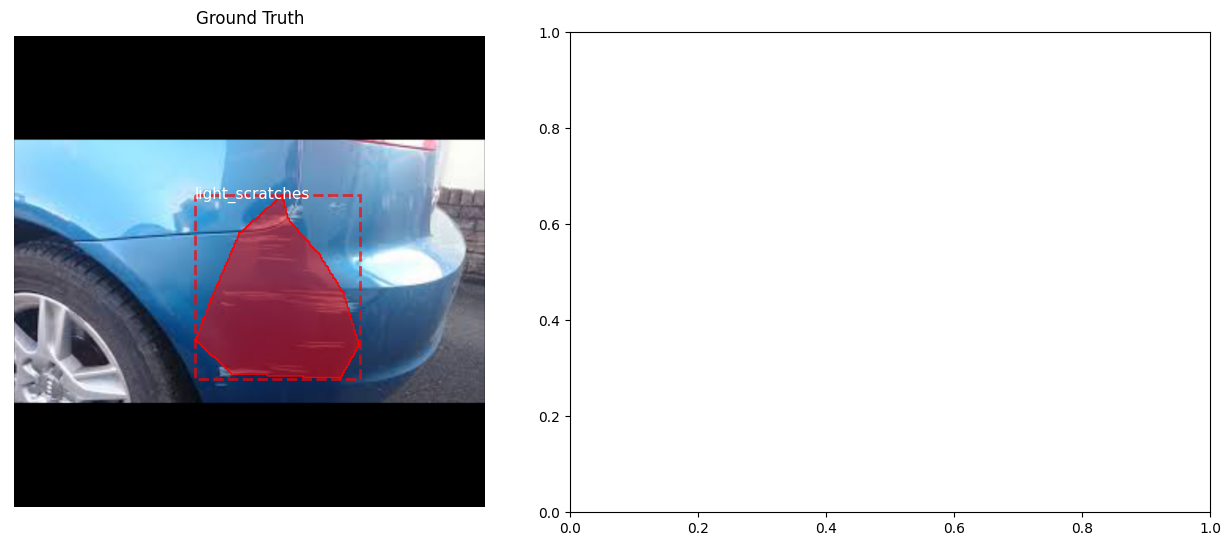

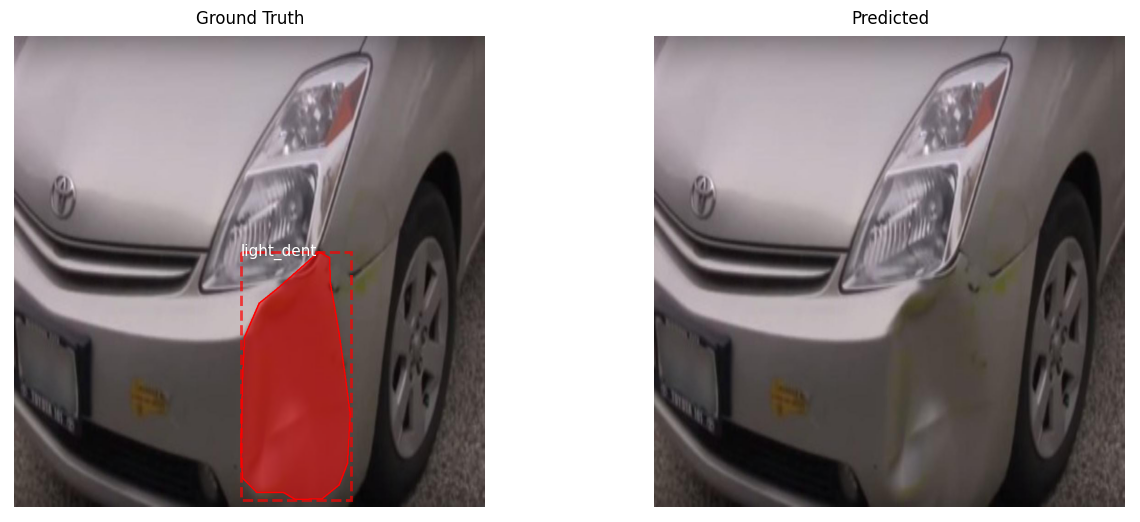


*** No instances to display *** 

Ground truth class id : [2 2 1 2]
Predicted class id : []
Ground truth mask shape is (1024, 1024, 4)
Predicted mask shape is (1024, 1024, 0)
AP is 0.0


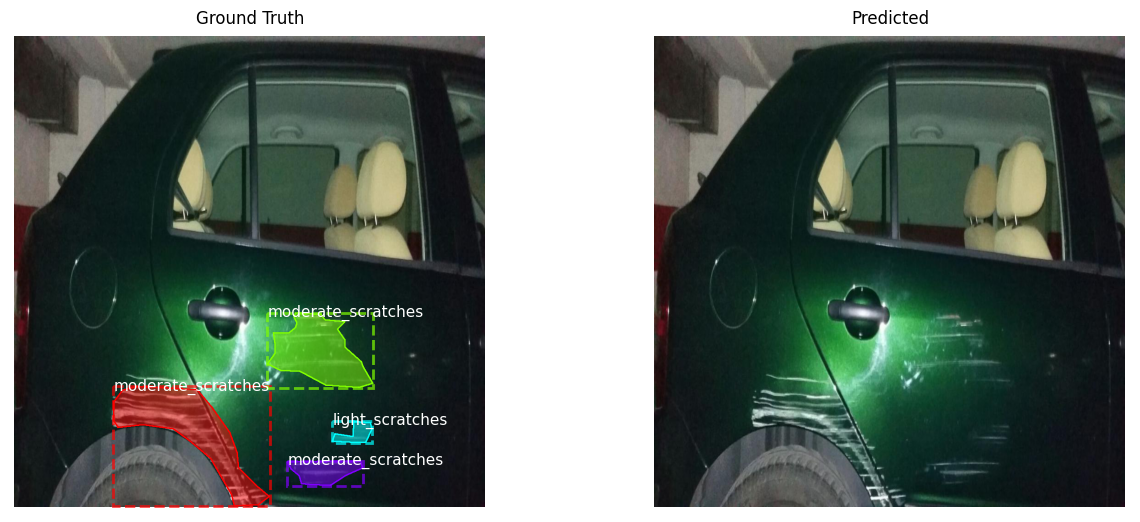


*** No instances to display *** 

Ground truth class id : [2]
Predicted class id : []
Ground truth mask shape is (1024, 1024, 1)
Predicted mask shape is (1024, 1024, 0)
AP is 0.0


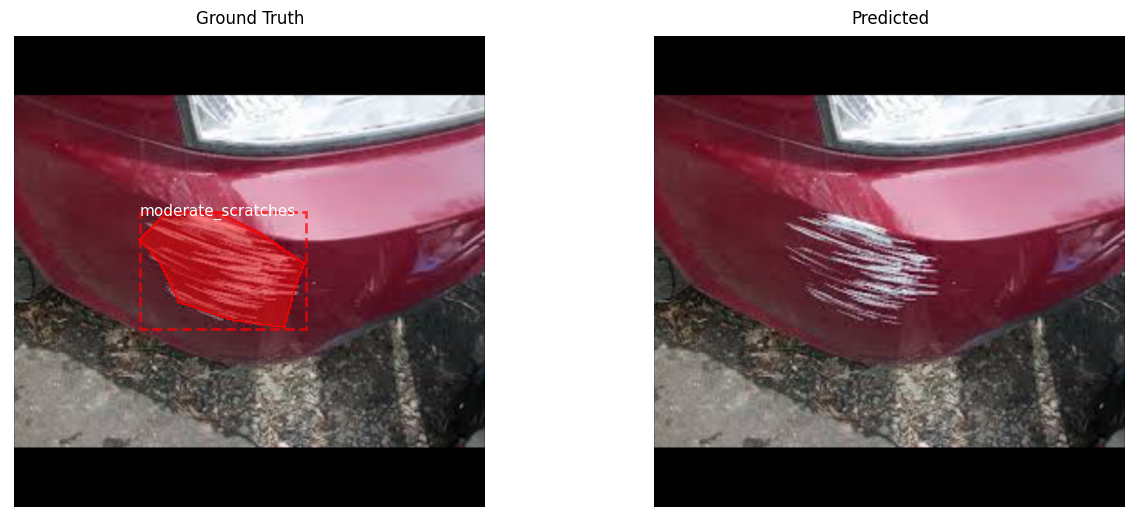

Ground truth class id : [4]
Predicted class id : [2 2]
Ground truth mask shape is (1024, 1024, 1)
Predicted mask shape is (1024, 1024, 2)
AP is 0.0


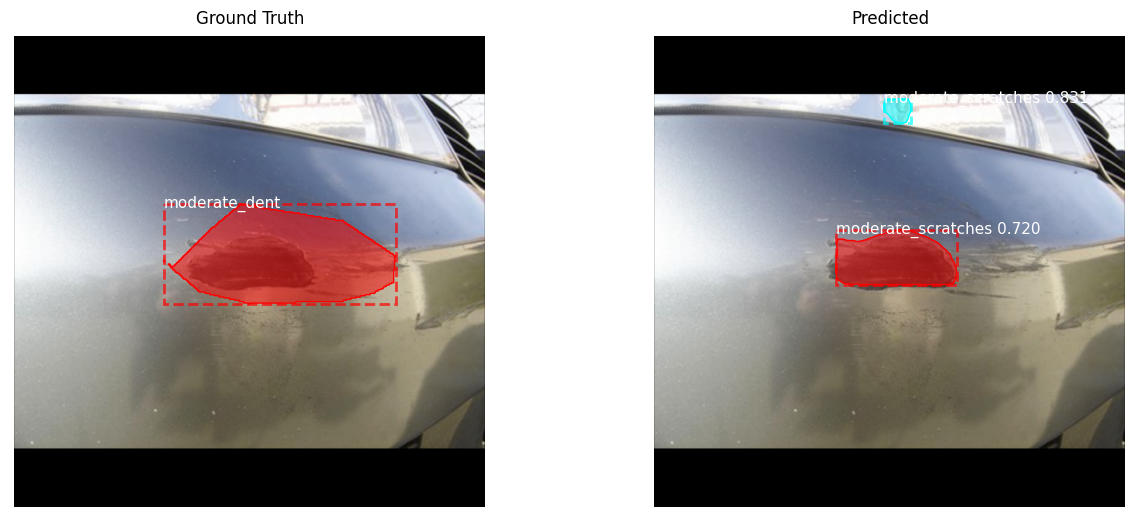

Ground truth class id : [4 3]
Predicted class id : [5 5 5 5 5 5]
Ground truth mask shape is (1024, 1024, 2)
Predicted mask shape is (1024, 1024, 6)
AP is 0.0


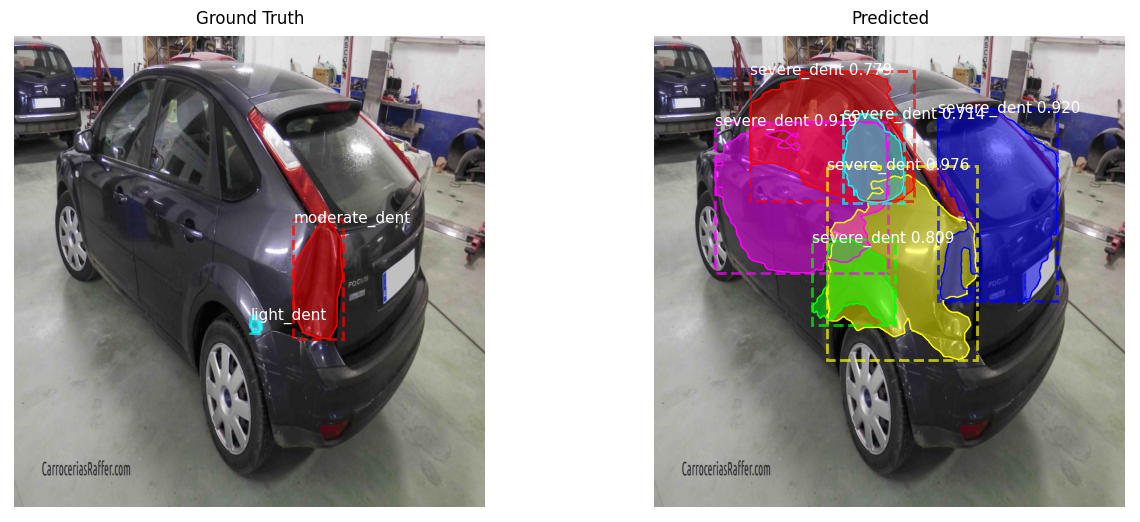

Ground truth class id : [2 2]
Predicted class id : [5 2]
Ground truth mask shape is (1024, 1024, 2)
Predicted mask shape is (1024, 1024, 2)
AP is 0.0


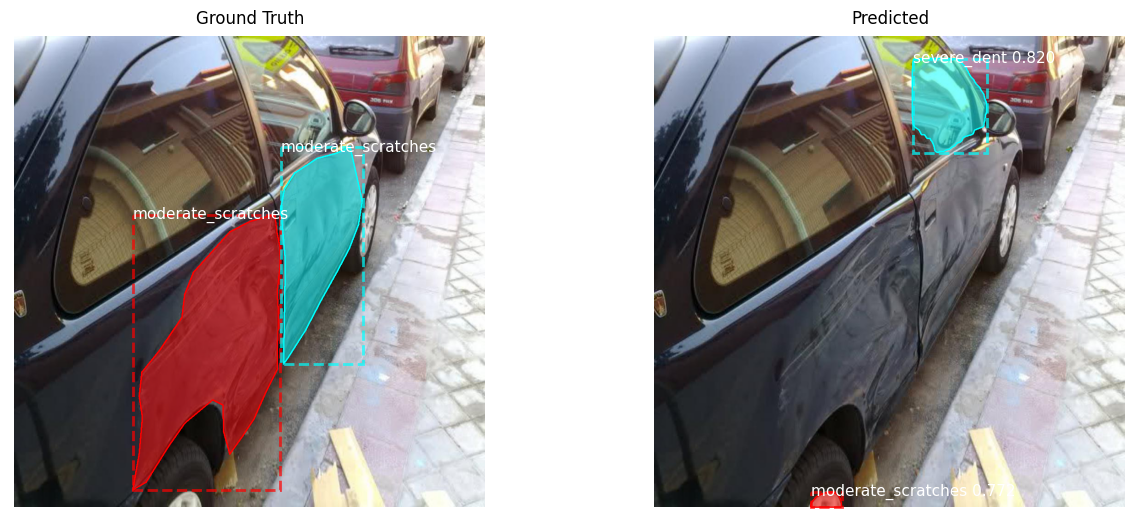


*** No instances to display *** 

Ground truth class id : [3 3]
Predicted class id : []
Ground truth mask shape is (1024, 1024, 2)
Predicted mask shape is (1024, 1024, 0)
AP is 0.0


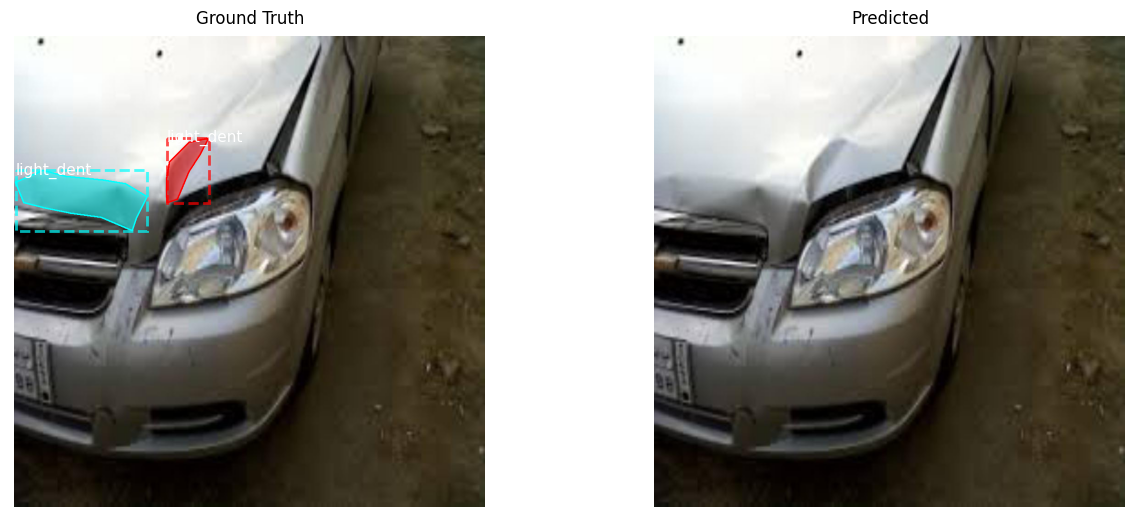


*** No instances to display *** 

Ground truth class id : [3 4]
Predicted class id : []
Ground truth mask shape is (1024, 1024, 2)
Predicted mask shape is (1024, 1024, 0)
AP is 0.0


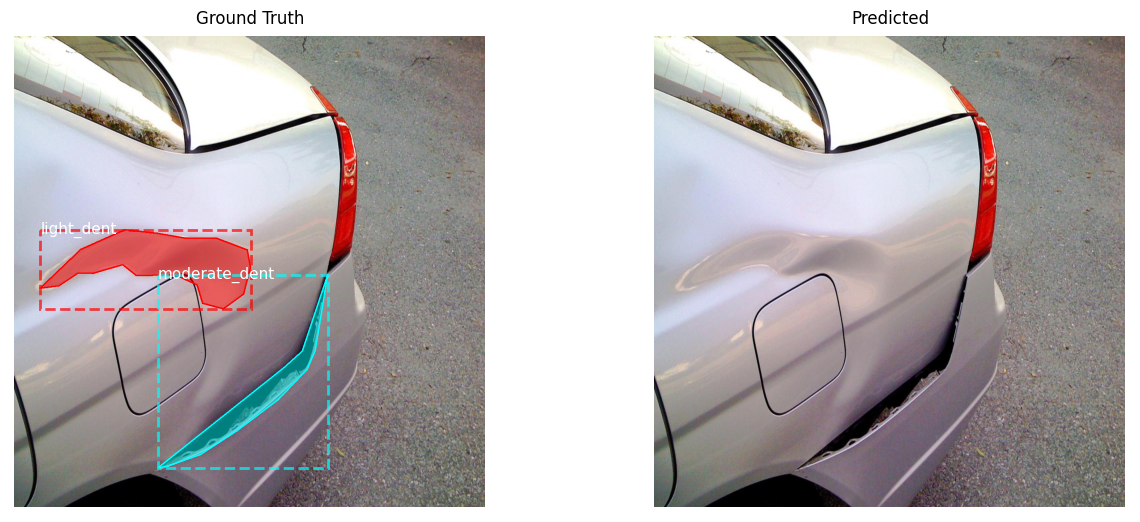


*** No instances to display *** 

Ground truth class id : [4]
Predicted class id : []
Ground truth mask shape is (1024, 1024, 1)
Predicted mask shape is (1024, 1024, 0)
AP is 0.0


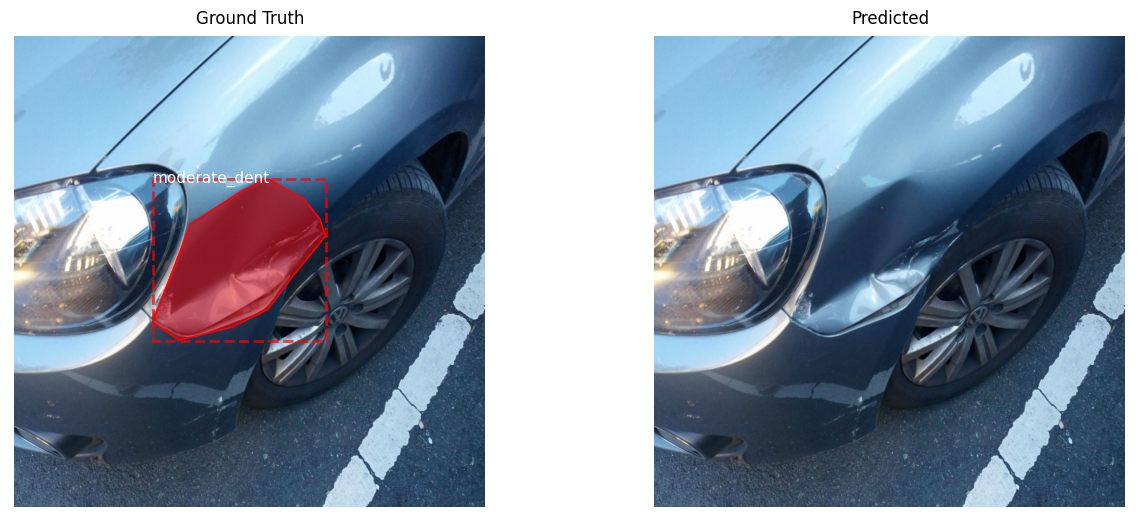

In [32]:
count = 0

# dataset = train_set
dataset = test_set

for image_id in dataset.image_ids:
    # load image, bounding boxes and masks for the image id
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

    # display ground truth image with masks and bounding boxes
    fig = plt.figure()
    axes1 = fig.add_axes([0, 0, 1, 1])
    axes2 = fig.add_axes([1, 0, 1, 1])
    display_instances(image, gt_bbox, gt_mask, gt_class_id, train_set.class_names, ax = axes1, title='Ground Truth')

    # Only show 10 pics coz takes quite some time
    count +=1
    if count == 10:
        break

    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)
    # extract results for first sample
    r = yhat[0]
    # calculate statistics, including AP
    AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

    # Getting predicted values from r
    pred_class_id = r['class_ids']
    pred_mask = r['masks']
    pred_bbox = extract_bboxes(pred_mask)
    # display predicted image with masks and bounding boxes
    display_instances(image, pred_bbox, pred_mask, pred_class_id, train_set.class_names, scores=r['scores'], ax=axes2, title='Predicted')

    print(f'Ground truth class id : {gt_class_id}')
    print(f'Predicted class id : {r["class_ids"]}')
    print(f"Ground truth mask shape is {gt_mask.shape}")
    print(f"Predicted mask shape is {r['masks'].shape}")

    print(f'AP is {AP}')
    plt.show()

In [22]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

IndexError: index 1024 is out of bounds for axis 1 with size 1024

In [31]:
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Test mAP: 0.000
